In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
import wandb
import tempfile
import os
from models.normalizing_flow import HierarchicalNormalizingFlowSB
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn


In [10]:
from train_flow_sb import unflatten, object_from_config

In [11]:
api = wandb.Api()

In [12]:
run = api.run('druhe/gw-src/24lgtnp2')

In [13]:
config = unflatten(run.config)

In [15]:
dataset = object_from_config(config, key='dataset')(**config['dataset'])

In [17]:
sb_weight = config['model']['sb_weight']

In [18]:
flows = object_from_config(config, key='flow')(**config['flow'])

In [19]:
checkpoints = [f for f in run.files() if f.name.endswith('.ckpt')]

In [22]:
tempdir = tempfile.TemporaryDirectory()

In [23]:
ckpt = checkpoints[-1]

In [24]:
ckpt_path = ckpt.download(root=tempdir.name, replace=True)

In [27]:
model = HierarchicalNormalizingFlowSB.load_from_checkpoint(ckpt_path.name, flows=flows, dataset=dataset, sb_weight=sb_weight)

INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /var/folders/d3/x840qlg17x1f92cnsrkq62fw0000gn/T/tmpbub_q56m
INFO:torch.distributed.nn.jit.instantiator:Writing /var/folders/d3/x840qlg17x1f92cnsrkq62fw0000gn/T/tmpbub_q56m/_remote_module_non_sriptable.py


In [28]:
dataset.gw_train_batch_size = 32
dataset.sel_train_batch_size = 32

In [29]:
gw_loader, sel_loader  = dataset.train_dataloader()

In [30]:
import hamiltorch

from torch.nn.utils import _stateless


In [31]:
def flatten_params(parameters):
    """
    flattens all parameters into a single column vector. Returns the dictionary to recover them
    :param: parameters: a generator or list of all the parameters
    :return: a dictionary: {"params": [#params, 1],
    "indices": [(start index, end index) for each param] **Note end index in uninclusive**

    """
    l = [torch.flatten(p) for p in parameters]
    indices = []
    s = 0
    for p in l:
        size = p.shape[0]
        indices.append((s, s+size))
        s += size
    flat = torch.cat(l).view(-1, 1)
    return flat, indices


def unflatten_params(flat_params, indices, model):
    """
    Gives a list of recovered parameters from their flattened form
    :param flat_params: [#params, 1]
    :param indices: a list detaling the start and end index of each param [(start, end) for param]
    :param model: the model that gives the params with correct shapes
    :return: the params, reshaped to the ones in the model, with the same order as those in the model
    """
    l = [flat_params[s:e] for (s, e) in indices]
    for i, p in enumerate(model.parameters()):
        l[i] = l[i].view(*p.shape)
    return tuple(nn.Parameter(p) for p in l)


In [32]:
params_flat, indices = flatten_params(model.parameters())
names = list(n for n, _ in model.named_parameters())


params_flat = params_flat.squeeze()

In [33]:
model=model.double()

params_init = hamiltorch.util.flatten(model).clone().double()


In [34]:
fmodel = hamiltorch.util.make_functional(model)

In [35]:
gw_iter = iter(gw_loader)
sel_iter = iter(sel_loader)

In [36]:
def log_prob(params, y=None):
    global gw_iter
    global sel_iter
    try:
        gw_batch = next(gw_iter)
        sel_batch = next(sel_iter)
    except StopIteration:
        gw_iter = iter(gw_loader)
        sel_iter = iter(sel_loader)
        gw_batch = next(gw_iter)
        sel_batch = next(sel_iter)

    gw_batch[0] = gw_batch[0].double()
    sel_batch[0] = sel_batch[0].double()
    
    prior = torch.distributions.Normal(params_init, 1).log_prob(params)

    params = unflatten_params(params, indices, model)
            
    out: torch.Tensor = _stateless.functional_call(model, {n: p for n, p in zip(names, params)}, (gw_batch, sel_batch))    
    ll = prior.sum() / len(out) + out.mean()
#     print(out.mean().item())
    return ll




In [40]:
N = 300
burn = 200
N_nuts = N + burn
step_size = 1e-3
L = 20

samples = hamiltorch.sample(
    log_prob, 
    params_init=params_init, 
    num_samples=N_nuts, 
    num_steps_per_sample=L, 
    step_size=step_size, 
    burn=burn, 
    sampler=hamiltorch.Sampler.HMC_NUTS,
    debug=True)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
Step: 0, Current Hamiltoninian: 28.485782784984018, Proposed Hamiltoninian: 37.17571746988816
REJECT
Step: 1, Current Hamiltoninian: 26.418339544512015, Proposed Hamiltoninian: 135.75453827014502
REJECT
Step: 2, Current Hamiltoninian: 28.85240132533172, Proposed Hamiltoninian: 30.472886641376988
REJECT
Step: 3, Current Hamiltoninian: 26.618291621616137, Proposed Hamiltoninian: 26.582932265081535
Accept rho: 0.0
Step: 4, Current Hamiltoninian: 32.39245655136684, Proposed Hamiltoninian: 32.47947593108174
Accept rho: -0.0870193797148957
Step: 5, Current Hamiltoninian: 25.28173772490174, Proposed Hamiltoninian: 25.102469002636184
Accept rho: 0.0
Step: 6, Current Hamiltoninian: 32.72583862122489, Proposed Hamiltoninian: 32.654649718902824
Accept rho: 0.0
Step: 7, Current Hamiltoninian: 26.396633248264166, Proposed Hamiltoninian: 27.51910419273139
REJECT
Step: 8, Current Hamil

Step: 71, Current Hamiltoninian: 30.944229038468734, Proposed Hamiltoninian: 30.84209856268842
Accept rho: 0.0
Step: 72, Current Hamiltoninian: 37.66037648033857, Proposed Hamiltoninian: 37.40571876156821
Accept rho: 0.0
Step: 73, Current Hamiltoninian: 35.91084071376203, Proposed Hamiltoninian: 35.595134942579286
Accept rho: 0.0
Step: 74, Current Hamiltoninian: 32.30427112866882, Proposed Hamiltoninian: 32.63395472439658
Accept rho: -0.32968359572775796
Step: 75, Current Hamiltoninian: 31.87695221846456, Proposed Hamiltoninian: 32.0774114159509
REJECT
Step: 76, Current Hamiltoninian: 25.721895577488734, Proposed Hamiltoninian: 25.71079074992891
Accept rho: 0.0
Step: 77, Current Hamiltoninian: 33.0707313354117, Proposed Hamiltoninian: 34.504741979993106
REJECT
Step: 78, Current Hamiltoninian: 28.448546925966006, Proposed Hamiltoninian: 28.313245366901565
Accept rho: 0.0
Step: 79, Current Hamiltoninian: 37.56423882238716, Proposed Hamiltoninian: 38.133813321062505
REJECT
Step: 80, Curre

Step: 142, Current Hamiltoninian: 24.999719420452475, Proposed Hamiltoninian: 24.59809665980694
Accept rho: 0.0
Step: 143, Current Hamiltoninian: 29.633297446257437, Proposed Hamiltoninian: 28.945200998474547
Accept rho: 0.0
Step: 144, Current Hamiltoninian: 36.53229282735187, Proposed Hamiltoninian: 39.34935097828401
REJECT
Step: 145, Current Hamiltoninian: 28.47976982071272, Proposed Hamiltoninian: 28.474520558177773
Accept rho: 0.0
Step: 146, Current Hamiltoninian: 31.628065277518985, Proposed Hamiltoninian: 31.67094426608366
Accept rho: -0.04287898856467365
Step: 147, Current Hamiltoninian: 28.307932175397145, Proposed Hamiltoninian: 28.175885512233595
Accept rho: 0.0
Step: 148, Current Hamiltoninian: 27.463226071543552, Proposed Hamiltoninian: 28.272215670070512
REJECT
Step: 149, Current Hamiltoninian: 30.348135842344256, Proposed Hamiltoninian: 30.1512951760288
Accept rho: 0.0
Step: 150, Current Hamiltoninian: 31.626227567658503, Proposed Hamiltoninian: 31.865343298913444
Accept 

Step: 211, Current Hamiltoninian: 31.904503624055575, Proposed Hamiltoninian: 32.023870868429114
Accept rho: -0.11936724437353874
Step: 212, Current Hamiltoninian: 40.075395628784904, Proposed Hamiltoninian: 40.25428634135835
REJECT
Step: 213, Current Hamiltoninian: 30.36052520129786, Proposed Hamiltoninian: 31.748059955636105
Accept rho: -1.387534754338244
Step: 214, Current Hamiltoninian: 40.06707106338425, Proposed Hamiltoninian: 40.07392479837246
Accept rho: -0.006853734988212068
Step: 215, Current Hamiltoninian: 37.52688534424778, Proposed Hamiltoninian: 40.52195560445307
REJECT
Step: 216, Current Hamiltoninian: 29.187076484760254, Proposed Hamiltoninian: 29.231356355180793
Accept rho: -0.044279870420538714
Step: 217, Current Hamiltoninian: 26.061748675480736, Proposed Hamiltoninian: 28.359139197400957
REJECT
Step: 218, Current Hamiltoninian: 29.957681472024532, Proposed Hamiltoninian: 30.79210558706886
REJECT
Step: 219, Current Hamiltoninian: 38.86120782626968, Proposed Hamiltoni

Step: 282, Current Hamiltoninian: 41.5261048800798, Proposed Hamiltoninian: 41.435355747193
Accept rho: 0.0
Step: 283, Current Hamiltoninian: 30.482006139513423, Proposed Hamiltoninian: 30.303136381724762
Accept rho: 0.0
Step: 284, Current Hamiltoninian: 26.633153062853893, Proposed Hamiltoninian: 26.70934801444846
Accept rho: -0.07619495159456591
Step: 285, Current Hamiltoninian: 30.3966254968174, Proposed Hamiltoninian: 30.237005023304256
Accept rho: 0.0
Step: 286, Current Hamiltoninian: 32.86402093503586, Proposed Hamiltoninian: 33.374383439615386
Accept rho: -0.5103625045795255
Step: 287, Current Hamiltoninian: 36.01512452543365, Proposed Hamiltoninian: 36.39680185188345
Accept rho: -0.3816773264498039
Step: 288, Current Hamiltoninian: 23.766886417546615, Proposed Hamiltoninian: 24.04433027357564
Accept rho: -0.27744385602902355
Step: 289, Current Hamiltoninian: 29.773848352521625, Proposed Hamiltoninian: 29.515659314098073
Accept rho: 0.0
Step: 290, Current Hamiltoninian: 34.09488

Step: 351, Current Hamiltoninian: 37.409090021953205, Proposed Hamiltoninian: 37.5329906250181
Accept rho: -0.12390060306489659
Step: 352, Current Hamiltoninian: 28.997861982739547, Proposed Hamiltoninian: 29.098769388222358
Accept rho: -0.10090740548281119
Step: 353, Current Hamiltoninian: 36.5703680495131, Proposed Hamiltoninian: 36.454429006152004
Accept rho: 0.0
Step: 354, Current Hamiltoninian: 39.24174894716033, Proposed Hamiltoninian: 38.98308839625606
Accept rho: 0.0
Step: 355, Current Hamiltoninian: 35.613987407178904, Proposed Hamiltoninian: 35.365024467214695
Accept rho: 0.0
Step: 356, Current Hamiltoninian: 32.07033213616077, Proposed Hamiltoninian: 32.38453474356284
Accept rho: -0.3142026074020663
Step: 357, Current Hamiltoninian: 32.19571448320962, Proposed Hamiltoninian: 32.460173692868004
Accept rho: -0.26445920965838354
Step: 358, Current Hamiltoninian: 30.509636864882317, Proposed Hamiltoninian: 30.421776734455683
Accept rho: 0.0
Step: 359, Current Hamiltoninian: 41.6

Step: 420, Current Hamiltoninian: 27.81363985284402, Proposed Hamiltoninian: 27.77872463558522
Accept rho: 0.0
Step: 421, Current Hamiltoninian: 31.111974870955798, Proposed Hamiltoninian: 31.14920473465545
Accept rho: -0.03722986369965042
Step: 422, Current Hamiltoninian: 27.44955329392678, Proposed Hamiltoninian: 27.723146339953967
Accept rho: -0.27359304602718737
Step: 423, Current Hamiltoninian: 36.90931698775721, Proposed Hamiltoninian: 36.98877944501828
Accept rho: -0.07946245726107293
Step: 424, Current Hamiltoninian: 32.516707582187536, Proposed Hamiltoninian: 32.555774896143646
Accept rho: -0.03906731395611018
Step: 425, Current Hamiltoninian: 28.968940980313768, Proposed Hamiltoninian: 28.93038084558455
Accept rho: 0.0
Step: 426, Current Hamiltoninian: 42.83291962948608, Proposed Hamiltoninian: 42.79910662682966
Accept rho: 0.0
Step: 427, Current Hamiltoninian: 28.46120978296878, Proposed Hamiltoninian: 28.39300840998463
Accept rho: 0.0
Step: 428, Current Hamiltoninian: 31.96

Step: 489, Current Hamiltoninian: 25.25509094441624, Proposed Hamiltoninian: 25.32426691049634
Accept rho: -0.06917596608010257
Step: 490, Current Hamiltoninian: 31.26327493825888, Proposed Hamiltoninian: 31.44343126215836
Accept rho: -0.1801563238994781
Step: 491, Current Hamiltoninian: 45.113949432531136, Proposed Hamiltoninian: 44.764620707189515
Accept rho: 0.0
Step: 492, Current Hamiltoninian: 28.483654962670755, Proposed Hamiltoninian: 28.26472621099076
Accept rho: 0.0
Step: 493, Current Hamiltoninian: 36.812465310231616, Proposed Hamiltoninian: 36.95719218756091
REJECT
Step: 494, Current Hamiltoninian: 29.191021208992915, Proposed Hamiltoninian: 29.318521870729406
Accept rho: -0.12750066173649088
Step: 495, Current Hamiltoninian: 31.041763155631077, Proposed Hamiltoninian: 31.246609916058794
Accept rho: -0.2048467604277171
Step: 496, Current Hamiltoninian: 32.88867627188358, Proposed Hamiltoninian: 32.97597318041276
Accept rho: -0.08729690852917571
Step: 497, Current Hamiltonini

In [41]:
samples = torch.stack(samples)

In [42]:
(gw_batch,) = next(gw_iter)


In [47]:
axes_names = []
axes = []

for n, ax in dataset.grid.items():
    axes_names.append(n)
    axes.append(ax)

m1, m2, z = np.stack(np.meshgrid(*axes, indexing="xy")).reshape(3, -1)

if dataset.has_normalization:
    raise NotImplementedError
    x, y = dataset.normalize_forward(x, y)

resolutions = [len(ax) for ax in axes]

input = np.stack([m1, m2, z], axis=-1)
input = torch.from_numpy(input)

In [48]:
def functional_call(model, flat_params):
    
    params = unflatten_params(flat_params, indices, model)

    out: torch.Tensor = _stateless.functional_call(model, {n: p for n, p in zip(names, params)}, input)    
    return out

In [50]:
with torch.no_grad():
    logprob = functional_call(model, params_init)
prob = logprob.exp().view(*resolutions)
pm1m2 = prob.sum(-1)

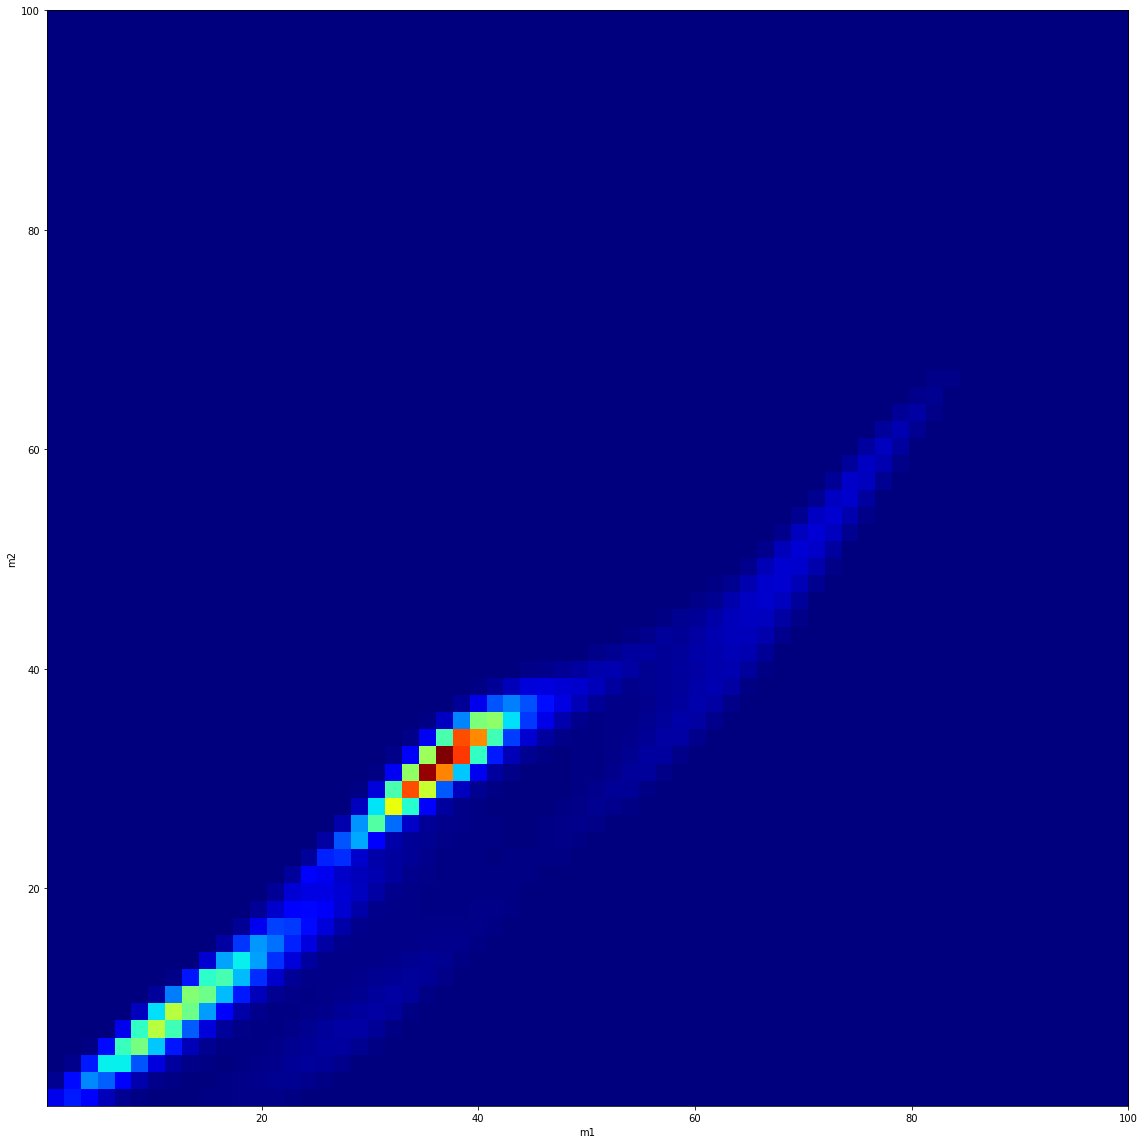

In [51]:
fig = plt.figure(figsize=(16, 16), facecolor="white")
plt.imshow(
    pm1m2,
    cmap="jet",
    origin="lower",
    extent=(
        axes[0][0],
        axes[0][-1],
        axes[1][0],
        axes[1][-1],
    ),  # origin='lower' changes the order
    aspect="auto",
)

plt.xlabel(axes_names[0])  # origin='lower' changes the order
plt.ylabel(axes_names[1])
plt.tight_layout()

In [52]:
probs = []
for sample in samples:
    with torch.no_grad():
        logprob = functional_call(model, sample)
    prob = logprob.exp().view(*resolutions)
    probs.append(prob)

In [53]:
probs = torch.stack(probs)

In [54]:
probs.shape

torch.Size([300, 64, 64, 64])

In [55]:
m1 = probs.sum((2, 3)).numpy()

In [56]:
m1_med = np.median(m1, axis=0)

In [57]:
m1_005 = np.percentile(m1, 5, axis=0)
m1_095 = np.percentile(m1, 95, axis=0)

(1e-05, 0.5)

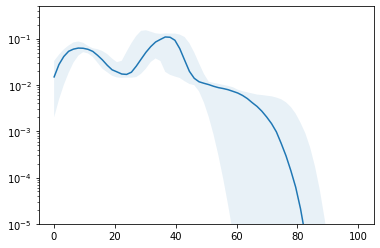

In [67]:
plt.plot(axes[0], m1_med)
plt.fill_between(axes[0], m1_005, m1_095, alpha=0.1)
plt.yscale('log')
plt.ylim((1e-5, 0.5))